# Analysis and improvement of data quality

In [145]:
# File management libraries
import os
import datetime
import io

# Data manipulation libraries
import pandas as pd
import numpy as np
import math

# Data visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Jupyter notebook integration libraries
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Label, Box, interactive
from ipywidgets import Layout, FileUpload, interact, Dropdown
from IPython.display import Markdown, display, clear_output


# Cloud storage libraries
import boto3


def printmd(string):
    display(Markdown(string))
    
# Global variables declaration
customised_missing_values = []

## Data collection

### Method 1: Direct upload

In [18]:
# ----- For testing purposes ------
file_path = "./Datasets/dementiadatacollectionoctober2014csv15kb.csv"
data = pd.read_csv(file_path)

### Method 2: Upload

In [26]:
# Shows the upload widget
upload = FileUpload(accept='')
upload

FileUpload(value={}, description='Upload')

### Method 2: Validating data upload

In [84]:
try:
    upload.value
    uploaded_filename = next(iter(upload.value))
    new_filename = uploaded_filename[:-3] + 'csv'
    content = upload.value[uploaded_filename]['content']
    file_path = os.path.abspath(uploaded_filename)
    filename, file_extension = os.path.splitext(file_path)
    data = pd.read_csv(io.BytesIO(content), header=0, escapechar='\\', encoding= 'unicode_escape')
    
except StopIteration:
    printmd("#### No file was selected. Re-use the upload button.")

### Data set preview 

In [71]:
data.head()

,OA11CD,LAD11NM,Percentage of people that received health care
0,E00024024,Westminster,17.953073
1,E00023833,Westminster,18.183844
2,E00023830,Westminster,18.732058
3,E00023831,Westminster,17.909357
4,E00024021,Westminster,17.185809


# General data set metadata

In [73]:
printmd("### Descriptive metadata\n")
    
filename, file_extension = os.path.splitext(file_path)
file_extension = file_extension.replace(".", "")

df_features = pd.DataFrame(index = data.columns)
df_features['Unique_Values'] = list(map(lambda x: data[x].value_counts().count(), data.columns))
df_features['Type_Data'] = list(map(lambda x: data[x].dtype, data.columns))

print("Format: {}".format(file_extension))
print("Size: {} elements".format(data.size))


printmd("### Structural metadata\n")
print("All column names: {}\n".format(list(data.columns)))
# data.isna().sum() is needed because the count function only returns the total number of non-na elements
print("Total number of values: \n\n{} ".format(data.count() + data.isna().sum()))
print("\nUnique values distribution: \n\n", df_features['Unique_Values'])
print("\nData types: \n\n", df_features['Type_Data'])



### Descriptive metadata


Format: csv
Size: 77838 elements


### Structural metadata


All column names: ['OA11CD', 'LAD11NM', 'Percentage of people that received health care']

Total number of values: 

OA11CD                                            25946
LAD11NM                                           25946
Percentage of people that received health care    25946
dtype: int64 

Unique values distribution: 

 OA11CD                                            25053
LAD11NM                                              33
Percentage of people that received health care    25053
Name: Unique_Values, dtype: int64

Data types: 

 OA11CD                                             object
LAD11NM                                            object
Percentage of people that received health care    float64
Name: Type_Data, dtype: object


# Values distribution for a specific column

In [76]:
def compute_values_dist_column(column_name):
    plt.figure(figsize=(20,5))
    if df_features['Unique_Values'][column_name] > 100:
         fig = px.histogram(data, x=column_name,
                            color_discrete_sequence =['#d595e8'],
                            barmode="group",
                            title="Values distribution for column '{}'".format(column_name)) \
                                .update_yaxes(categoryorder="total ascending")
    else:
         fig = px.histogram(data, y=column_name,
                            color_discrete_sequence =['#d595e8'],
                            barmode="group", 
                            title="Values distribution for column '{}'".format(column_name)) \
                                .update_yaxes(categoryorder="total ascending")
    fig.show()


def on_change(change):
    with outs:
        clear_output(wait=True)
        if change['type'] == 'change' and change['name'] == 'value':
            compute_values_dist_column(change['new'])

            
printmd("#### Select a column from the list below:")
w = widgets.Dropdown(options = data.columns, description="Column: ", value = None)
outs = widgets.Output()

w.observe(on_change, names='value')

display(w)
display(outs)

# Clean up
with outs:
    clear_output()


#### Select a column from the list below:

Dropdown(description='Column: ', options=('OA11CD', 'LAD11NM', 'Percentage of people that received health care…

Output()

#  Unique values for a specific column

In [80]:
# Retrieve the unique values and their number of appearances
def get_unique_values_count(data, selected_column_name):
    return [data[selected_column_name].value_counts().index.tolist(), data[selected_column_name].value_counts()]

# Table creation method
def unique_values_table_generation(unique_values, column_name):
    try:
        plt.figure(figsize=(40, 15))
    
        # Display the table
        fig = go.Figure(data=[go.Table(
                header = dict(values=[column_name, "Number of appearances"],
                         fill_color='paleturquoise', align='center'),
                cells = dict(values = [unique_values[0], unique_values[1]],
                             font = dict(family="Times New Roman", size=14,)))])
        fig.update_layout(title_text="Unique values for column %s" % column_name,
                          title_font_size=24, title_x=0.5, autosize=True)
        fig.show()
    except KeyError:
        printmd("## Please select a column.")
    except IndexError:
        printmd("## Please select a column.")

        
# Function called when a drop-down selection is made 
def on_change(change):
    with outs:
        # Refresh the output for displaying a new figure
        clear_output(wait=True)
        if change['type'] == 'change' and change['name'] == 'value':
            
            # Retrieve the number of unique values
            unique_values = get_unique_values_count(data, change['new'])
            
            # Display the number of unique values
            unique_values_table_generation(unique_values, change['new'])

# Widget definition
outs = widgets.Output()
printmd("#### Select a column from the list below:")
w = widgets.Dropdown(options = data.columns, description="Column: ", value = None)
w.observe(on_change, names='value')
display(w)
display(outs)

# Clean-up process
with outs:
    clear_output()

#### Select a column from the list below:

Dropdown(description='Column: ', options=('OA11CD', 'LAD11NM', 'Percentage of people that received health care…

Output()

<Figure size 2880x1080 with 0 Axes>

<Figure size 2880x1080 with 0 Axes>

# Assessing the plausibility of the dataset

## Column similarity

In [ ]:
f, ax = plt.subplots(figsize=(20, 11))
try:
    printmd("### Heatmap for column similarity: ")
    df = data.apply(lambda x: x.factorize()[0]).corr()
    sns.heatmap(df, annot=True, annot_kws={"size": 10}, linewidths=.5, cmap="BuPu")
except ValueError:
    pass

### Similarity between missing values indexes

In [66]:
def get_cosine_similarity(req_arr1, req_arr2):
    req_arr1 = req_arr1[0]
    req_arr2 = req_arr2[0]
    if len(req_arr2) > len(req_arr1):
        req_arr1 = list(map(lambda x: 0 if x not in req_arr1 else x, req_arr2))
    elif len(req_arr1) > len(req_arr2):
        req_arr2 = list(map(lambda x: 0 if x not in req_arr2 else x, req_arr1))
    dot_product = sum(x * y for (x, y) in zip(req_arr1, req_arr2))
    magnitude_arr1 = math.sqrt(sum(pow(x, 2) for x in req_arr1))
    magnitude_arr2 = math.sqrt(sum(pow(x, 2) for x in req_arr2))
    if magnitude_arr1 == 0 or magnitude_arr2 == 0:
        return 0.0
    else:
        return (dot_product / (magnitude_arr1 * magnitude_arr2))
    
def has_null_value(data, null_list):
    null_elem = []
    for c in data.columns:
        for elem in data[c]:
            if elem in null_list:
                null_elem.append(elem)
    return null_elem

values = pd.Series()
for column in data.columns:
    values[column] = np.where(data[column].isnull() | data[column].isin(['NIL RETURN']))

missing_val_indexes = values.drop(values.index[[index for index, value in enumerate(values) if value[0].size == 0]])
print(missing_val_indexes)

df = pd.DataFrame(columns = missing_val_indexes.index, index =  missing_val_indexes.index)

for current_index_row in range(len(missing_val_indexes)):
    for current_index_column in range(len(missing_val_indexes)):
        df.iloc[current_index_row][current_index_column] = float(get_cosine_similarity(missing_val_indexes[current_index_row], missing_val_indexes[current_index_column]))
        
for column in df.columns:
    df[column] = df[column].astype('float')

printmd("## Similarity matrix for missing values indexes: ")    
display(df)


city            ([4],)
batch          ([12],)
becktnt1    ([0, 12],)
becktlt1        ([0],)
test            ([2],)
dtype: object


<ipython-input-66-8eaaac84cb03>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  values = pd.Series()


## Similarity matrix for missing values indexes: 

,city,batch,becktnt1,becktlt1,test
city,1.0,1.0,0.0,0.0,1.0
batch,1.0,1.0,1.0,0.0,1.0
becktnt1,0.0,1.0,1.0,0.0,0.0
becktlt1,0.0,0.0,0.0,0.0,0.0
test,1.0,1.0,0.0,0.0,1.0


### Similarity heatmap for missing values indexes

## Heatmap for missing values similarity: 

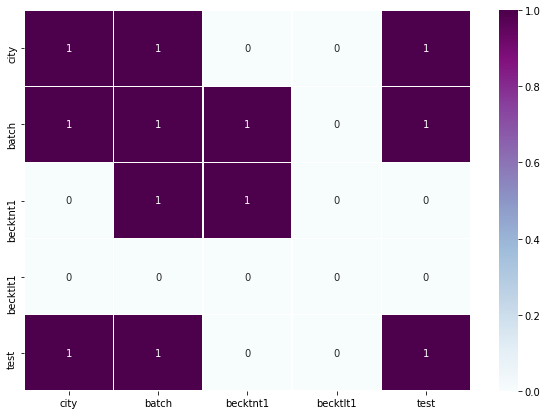

In [67]:
f, ax = plt.subplots(figsize=(10, 7))
try:
    printmd("## Heatmap for missing values similarity: ")
    sns.heatmap(df, annot=True, annot_kws={"size": 10}, linewidths=.5, cmap="BuPu")
except ValueError:
    pass

# Missing values analysis

In [81]:
# This list will contain the users' configured missing values
customised_missing_values = []

def on_submit_button_click(b):
    # Avoids adding empty strings to the list
    if len(values.value) > 0:
    
        # The values are separated by commas
        result = [x.strip() for x in values.value.split(',')]
        customised_missing_values.extend(result)
        
        # Report to user the current state of the list
        print("Customised missing values list: {}".format(customised_missing_values))

    
printmd("### Customised missing value")
printmd("Any entry that is equal to this customised missing value will be marked as 'missing'. \
        If you have made a mistake, please rerun the cell.")
printmd("You can mention more values by separating them by commas - e.g -9, 10, NULL")

# User interface details
values = widgets.Text(description='Value')
button = widgets.Button(description="Submit")
Box = widgets.HBox([values, button])

button.on_click(on_submit_button_click)
Box

### Customised missing value

Any entry that is equal to this customised missing value will be marked as 'missing'. If you have made a mistake, please rerun the cell.

You can mention more values by separating them by commas - e.g -9, 10, NULL

In [151]:
def get_missing_values_count(df_obj):
    # Initialise the counter
    count = 0
    
    # Count the number of null values, if there are any
    null_values = df_obj.isnull()
    general_missing_values_count = null_values.value_counts()
    
    if general_missing_values_count.size == 2:
         count += general_missing_values_count[True]
    
    # Count the number of na values, if there are any
    na_values = df_obj.isna()
    general_missing_values_count = na_values.value_counts()
    
    if general_missing_values_count.size == 2:
         count += general_missing_values_count[True]
    
    # Return the total number of null and na missing values
    return count

def check_missing_values(df_obj):
    resultDict = {}
    count = 0
    
    general_missing_values = get_missing_values_count(df_obj)
    if general_missing_values:
        count += general_missing_values
    
    # Check for empty values or for customised missing values
    for elem in df_obj:
        if elem in customised_missing_values or len(str(elem).strip()) == 0:
            resultDict[count] = True
        else:
            resultDict[count] = False
        count +=1
    return pd.Series(resultDict)

# Retrieve the missing information from the data object
missing_values = pd.DataFrame()
missing_data = data.apply(lambda x: sum(check_missing_values(x)), axis=0).sort_values(ascending=False)

# Retrieve the number of missing values per column
missing_values['missing_values_count'] = missing_data.values

# Retrieve the name of the columns with missing data
missing_values['column_name'] = missing_data.index

# Retrieve the column name and the count of its missing values that are not 0
missing_values = missing_values[missing_values['missing_values_count'] != 0]


if missing_values.empty == True and data.isna().values.any() == False:
    printmd("### There are no missing values in the data.")
else:
    printmd("### The missing values:")
    print(missing_values)

### The missing values:

    missing_values_count column_name
0                   5825    yesvgst4
1                   5107    yesvgst3
2                   4180    yesvgst2
3                   4071        test
4                   4010    yesvtlt4
5                   4010    yesvtnt4
6                   4010    yesvyrt4
7                   3100    yesvgst1
8                   1332    beckyrt2
9                   1332    becktnt2
10                  1332    becktlt2
11                  1322    yesvtlt3
12                  1322    yesvyrt3
13                  1322    yesvtnt3
14                   892    becksct1
15                   687    yesvtlt2
16                   687    yesvtnt2


# Cleaning the dataset

In [59]:
def save_to_aws():
    try:
        session = boto3.Session(
            aws_access_key_id=access_key_text.value,
            aws_secret_access_key=secret_access_key_text.value
        )
        s3 = session.resource('s3')

        data.to_csv('new_dataset.csv')
        s3.meta.client.upload_file(Filename='new_dataset.csv', Bucket=bucket_text.value, Key='new_dataset.csv')
    except boto3.exceptions.S3UploadFailedError:
        print(">> The file couldn't be saved to AWS - Invalid AWS credentials.")
        
def get_10_related_columns(column_name, data):
    df = data.apply(lambda x: x.factorize()[0]).corr()
    df = df.sort_values(by=column_name, ascending=False, axis=1)    
    top_10_related_columns = []
        
    for row in df:
        if row == column_name:
            for i in range(len(df)):
                top_10_related_columns.append(df.columns[i])
                if i + 1== len(data.columns) or len(top_10_related_columns) == 10:
                    return top_10_related_columns
                
# This drops empty strings, NA values and any values that the user 
# added to the customisation of missing values step
def remove_column(column_name):
    print("Initial shape of data set: ", data.shape)
    data.drop([column_name], axis=1, inplace=True)
    print("After removal shape of data set:", data.shape)
    columnDrop.options = data.columns
    print("Column removed!")
   
        
# This function is performed in place 
# (directly changing the value of the variable data)
def modify_values(column_name, replace_value):
    try:
        data[[column_name]] = data[[column_name]].fillna(value=replace_value)
        data[[column_name]] = data[[column_name]].replace(' ', replace_value)
        data[[column_name]] = data[[column_name]].replace('', replace_value)

        if len(customised_missing_values) > 0:
            for mv in customised_missing_values:
                data[[column_name]] = data[[column_name]].replace(int(float(mv)), replace_value)
        print("The missing values have been replaced with {}".format(replace_value))
    except TypeError:
        print(">> Error found when selecting transformation.")
        
def on_button_clicked(b):
    with output:
        try:
            column_name = columnDrop.value
            if transformationDrop.value == "Remove column":
                remove_column(column_name)
                columnDrop.options = data.columns
            elif transformationDrop.value == "Change values to 0":
                modify_values(column_name, 0)
            elif transformationDrop.value == "Change values to NULL":
                modify_values(column_name, 'NULL')
            
            if saveToDrop.value == "Your computer":
                data.to_csv('new_dataset.csv')
                print("The newly generated data set has been saved to your computer under the name: {}".format("new_dataset.csv"))
            else:
                save_to_aws()
        except TypeError as e:
            print(">> This action is not supported on the mentioned column!", e)

            
layout = Layout(display='flex')

printmd("## Missing values dataset transformation")
columnDrop = Dropdown(description="Column", options = data.columns, layout=layout, style = {'description_width': 'initial'}, value = None)
transformationDrop = Dropdown(description="Transformations", options =  ["Remove column", "Change values to 0", "Change values to NULL"], layout=layout, style = {'description_width': 'initial'}, value = None)
applyDrop = Dropdown(description="Apply to", layout=layout, style = {'description_width': 'initial'}, value = None)
relatedColumnsDrop = Dropdown(description="Related columns", layout=layout, style = {'description_width': 'initial'}, value = None)
saveToDrop = Dropdown(description="Save to", options= ["Your computer", "AWS"], layout=layout, style = {'description_width': 'initial'}, value = None)

access_key_text = widgets.Text(description='AWS Key', placeholder="AWS access key ID")
secret_access_key_text = widgets.Text(description='AWS Key', placeholder="AWS secret access key ID")
bucket_text = widgets.Text(description='AWS Bucket', placeholder="Bucket Name")
output = widgets.Output()


button = widgets.Button(description="Submit")
output = widgets.Output()
button.on_click(on_button_clicked)



def update_columnDrop_options(*args):
    applyDrop.options = [columnDrop.value, "Related columns"]
columnDrop.observe(update_columnDrop_options) 

def update_applyDrop_options(*args):
    if applyDrop.value == "Related columns":
        relatedColumnsDrop.options = get_10_related_columns(columnDrop.value, data)
    else:
        relatedColumnsDrop.options = ''
applyDrop.observe(update_applyDrop_options) 



@interact(column = columnDrop, transformations=transformationDrop, apply = applyDrop, save_to = saveToDrop, related_col = relatedColumnsDrop)
def print_arguments(column, transformations, apply, save_to, related_col):
    if save_to == "AWS":
        display(access_key_text, secret_access_key_text, bucket_text)
    if column is not None and transformations is not None and apply is not None and save_to is not None:
        if apply == "Related columns":
            if len(related_col) > 0 :
                display(button, output)
        else: 
            display(button, output)


## Missing values dataset transformation

interactive(children=(Dropdown(description='Column', layout=Layout(display='flex'), options=('pidno', 'city', …